# Demo 1: phase conservation of backwards propagation

A demo to see if backwards propagation correctly calculates the initial phase of a point source.                     We generate three point sources, at phases of -3, 0 and 3 radians.
These fields are propagated to a plane above the point sources and propagated backwards.                             Then, the mean phase of the field below is calculated and compared to the original phase value.                     Finally, the phase differences are plotted as function of original phase.                                

2026-02-27 16:10:11 - WARNING - System override set to True. 
2026-02-27 16:10:11 - INFO - Added plane source to system. 
2026-02-27 16:10:11 - INFO - Added plane plane_up to system. 
2026-02-27 16:10:11 - INFO - Added plane plane_down to system. 
2026-02-27 16:10:11 - INFO - Translated element plane_up by ('0.000e+00', '0.000e+00', '1.000e+03') millimeters. 
2026-02-27 16:10:11 - WORK - *** Starting PO propagation *** 
2026-02-27 16:10:11 - WORK - Propagating PS_source on source to plane_up, propagation mode: JMEH. 
2026-02-27 16:10:11 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-27 16:10:11 - WORK - ... Calculating ... 
2026-02-27 16:10:12 - WORK - *** Finished: 0.262 seconds *** 
2026-02-27 16:10:12 - WORK - *** Starting PO propagation *** 
2026-02-27 16:10:12 - WORK - Propagating JM_up on plane_up to plane_down, propagation mode: JMEH. 
2026-02-27 16:10:12 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-27 16:10:12 - WORK - ... Calculating ... 
20

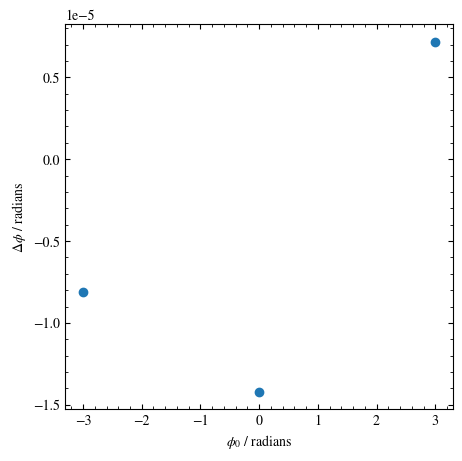

In [7]:
#%matplotlib widget 
# Uncomment for interactive plots when running the notebook!
# Requires installation of the ipympl package

import matplotlib.pyplot as pt

import numpy as np
from pathlib import Path

from PyPO.System import System
from PyPO.Enums import Units, FieldComponents, CurrentComponents

s = System()

D = 1000 # Distance between point source and upper screen.
    
source = {
        "name"      : "source",
        "gmode"     : "xy",
        "lims_x"    : np.array([-0.01, 0.01])*Units.MM,
        "lims_y"    : np.array([-0.01, 0.01])*Units.MM,
        "gridsize"  : np.array([101, 101])
        }

plane_up = {
        "name"      : "plane_up",
        "gmode"     : "uv",
        "lims_u"    : np.array([0, 10])*Units.MM,
        "lims_v"    : np.array([0, 360])*Units.DEG,
        "gridsize"  : np.array([201, 200]),
        "flip"      : True
        }

plane_down = {
        "name"      : "plane_down",
        "gmode"     : "uv",
        "lims_u"    : np.array([0, .010])*Units.MM,
        "lims_v"    : np.array([0, 360])*Units.DEG,
        "gridsize"  : np.array([101, 100])
        }

s.addPlane(source)
s.addPlane(plane_up)
s.addPlane(plane_down)

ph_diff = []
phases = np.linspace(-3, 3, 3)
for ph in phases:
    PSDict = {
            "name"      : "PS_source",
            "lam"       : 1,
            "E0"        : 1,
            "phase"     : ph,
            "pol"       : np.array([1,0,0])
            }

    s.createPointSource(PSDict, "source")

    s.translateGrids("plane_up", np.array([0, 0, D])*Units.MM)

    runPODict = {
            "t_name"    : "plane_up",
            "s_current" : "PS_source",
            "exp"       : "fwd",
            "mode"      : "JMEH",
            "name_JM"   : "JM_up",
            "name_EH"   : "EH_up",
            }

    runPODict_bwd = {
            "t_name"    : "plane_down",
            "s_current" : "JM_up",
            "exp"       : "bwd",
            "mode"      : "JMEH",
            "name_JM"   : "JM_down",
            "name_EH"   : "EH_down",
            }

    s.runPO(runPODict)
    s.runPO(runPODict_bwd)

    # The mean phase is simply calculated as the means of the phase over the surface.
    phase_Ex = np.mean(np.angle(s.fields["EH_down"].Ex))
    ph_diff.append(ph - phase_Ex)

fig, ax = pt.subplots(1,1, figsize=(5,5))
ax.scatter(phases, ph_diff)
ax.set_xlabel(r"$\phi_0$ / radians")
ax.set_ylabel(r"$\Delta \phi$ / radians")
pt.show()

In the image above, $\phi_0$ represents the initial phase and $\Delta \phi = \phi_0 - \phi_\mathrm{bw}$ the phase difference between the initial phase and mean backwards propagated phase. It can be seen that the difference is small for all $\phi_0$.

## Plot the fields to diagnose

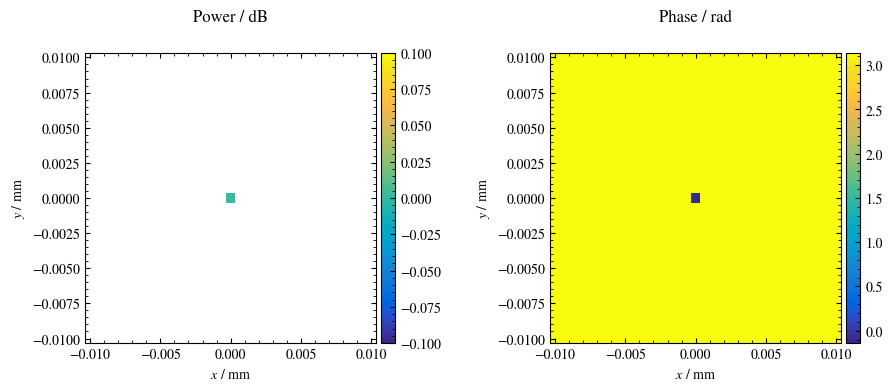

In [2]:
s.plotBeam2D("PS_source", CurrentComponents.My)

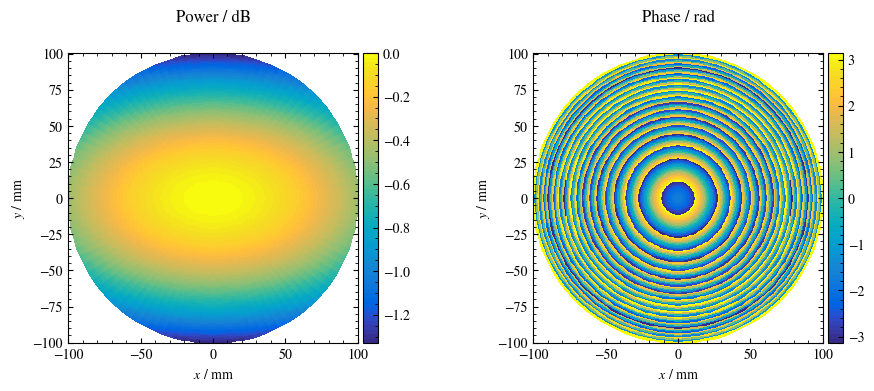

In [3]:
s.plotBeam2D("JM_up", CurrentComponents.Jx)

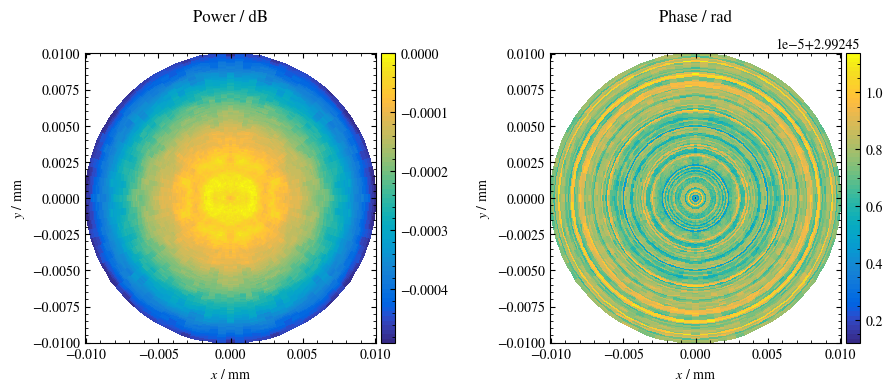

In [4]:
s.plotBeam2D("EH_down", FieldComponents.Ex)